# ⚠️ Maps in reflected light

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import starry

starry.config.lazy = False

In [74]:
map = starry.Map(ydeg=15, inc=90, obl=23.5, reflected=True, quiet=True)
map.load("earth")

In [7]:
map.show(theta=np.linspace(0, 360, 50))

Here's the phase curve of the Earth over one rotation at 8 different illumination phases:

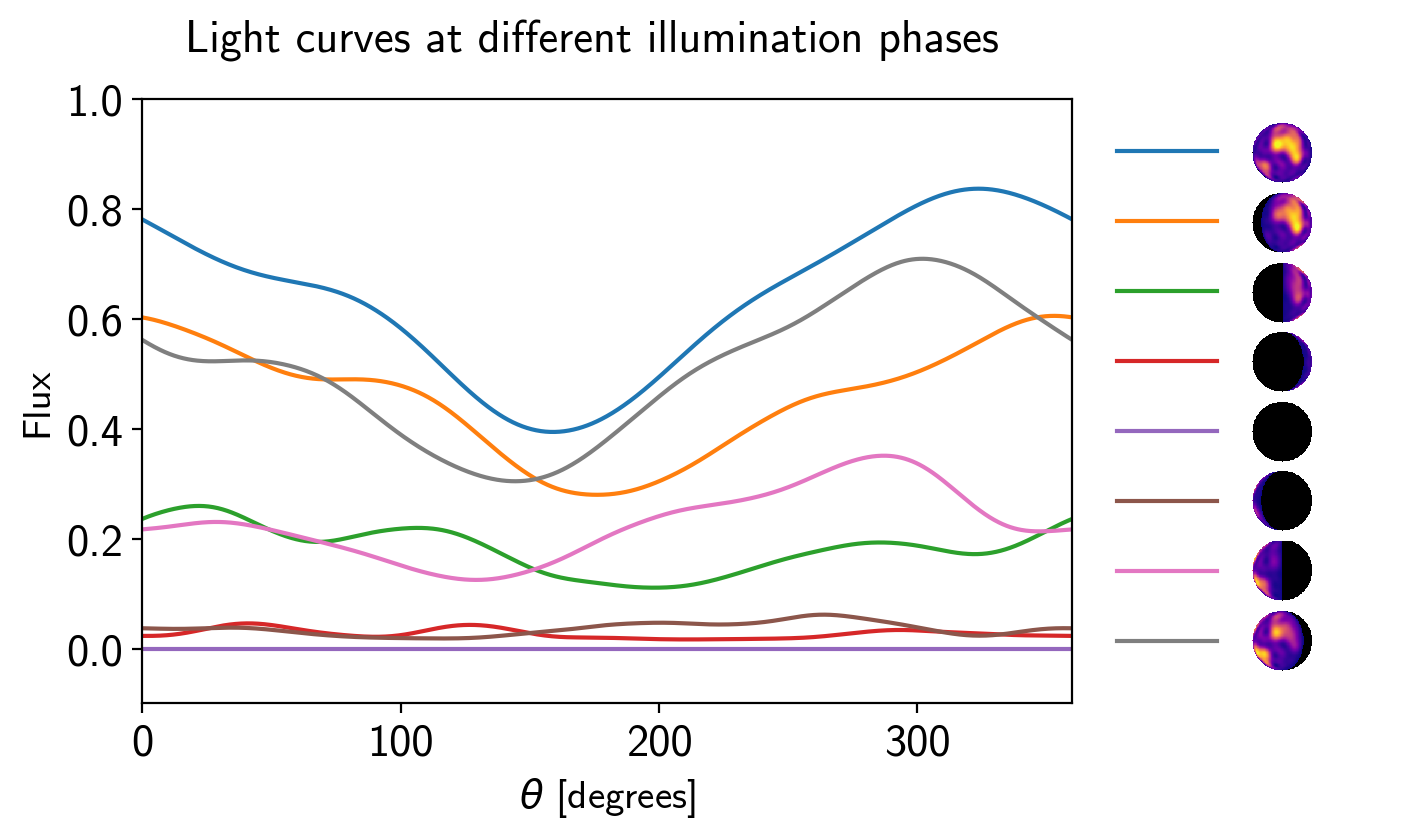

In [79]:
fig = plt.figure(figsize=(6, 4))
theta = np.linspace(0, 360, 1000)
phis = np.linspace(0, 360, 9)[:-1]
source = [[np.cos((phi - 90) * np.pi / 180), 0, -np.sin((phi - 90) * np.pi / 180)] for phi in phis]
for n, phi in enumerate(phis):
    plt.plot(theta, map.flux(theta=theta, source=source[n]), label=phi)
plt.xlim(0, 360)
plt.ylim(-0.1, 1.0)
plt.xlabel(r"$\theta$ [degrees]", fontsize=14)
plt.ylabel("Flux", fontsize=14)
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, frameon=False)
for text in legend.get_texts():
    text.set_color("w")
cmap = plt.get_cmap("plasma")
cmap.set_under("#000000")
for n in range(8):
    ax = fig.add_axes((1.05, 0.775 - 0.087 * n, 0.05, 0.075))
    img = map.render(res=100, source=source[n])
    ax.imshow(img, cmap=cmap, origin="lower", vmin=1e-5, vmax=0.75)
    ax.axis('off');
plt.suptitle("Light curves at different illumination phases", fontsize=16);

Here's the phase curve of the Earth over one year in orbit around the Sun:

Compiling `flux`... Done.


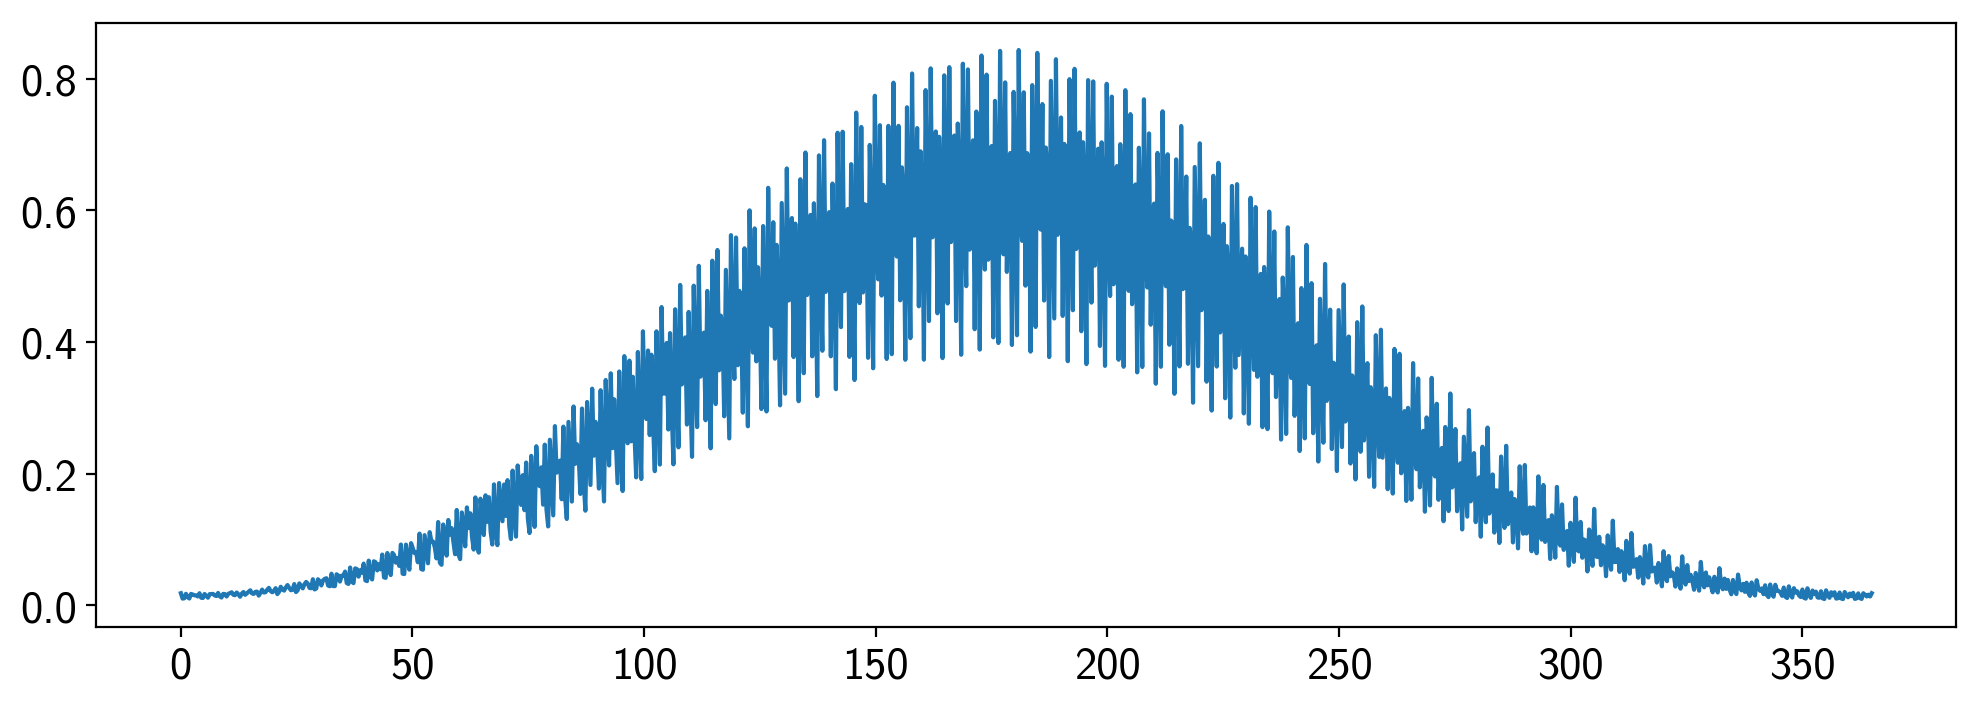

In [89]:
sun = starry.Primary(starry.Map(L=0))
earth = starry.Secondary(map, porb=365.0, prot=1.0, m=0.0, inc=60)
earth.map.inc = earth.inc = 60
sys = starry.System(sun, earth)

t = np.linspace(0, 365.0, 1000)
plt.plot(t, sys.flux(t));